<a href="https://colab.research.google.com/github/inokchoi/ComputerVision/blob/main/Super_Resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Dataset.h5 읽어오기

In [ ]:
import h5py
import numpy as np

#hf = h5py.File('/content/drive/My Drive/Dataset.h5','r')
hf = h5py.File('/content/drive/My Drive/Colab Notebooks/19-2 medical image/Data 6/Dataset.h5','r')

X_train = np.array(hf.get('X_train'))
Y_train = np.array(hf.get('Y_train'))

X_val = np.array(hf.get('X_val'))
Y_val = np.array(hf.get('Y_val'))

X_test = np.array(hf.get('X_test'))
Y_test = np.array(hf.get('Y_test'))

X_train = X_train.astype('float32')
Y_train = Y_train.astype('float32')

X_val = X_val.astype('float32')
Y_val = Y_val.astype('float32')

X_test = X_test.astype('float32')
Y_test = Y_test.astype('float32')

print(X_train.shape)
print(Y_train.shape)

print(X_val.shape)
print(Y_val.shape)

print(X_test.shape)
print(Y_test.shape)
hf.close()  # Close hdf5 reader


(756, 1, 512, 512)
(756, 1, 512, 512)
(252, 1, 512, 512)
(252, 1, 512, 512)
(252, 1, 512, 512)
(252, 1, 512, 512)


# Visualize Dataset

Text(0.5, 1.0, 'Label')

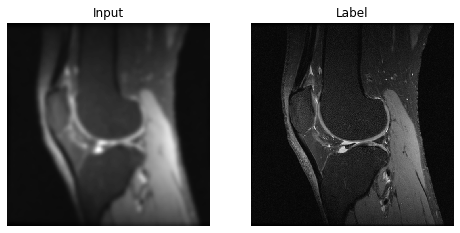

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(X_train[100].squeeze(), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow(Y_train[100].squeeze(), cmap='gray')
plt.axis('off')
plt.title('Label')


# Dataset Loader - Utility Function

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms
import numpy as np

class SR_Dataset(Dataset):
    def __init__(self,X_train,Y_train, transform=None):
        self.x_data = torch.from_numpy(X_train)
        self.y_data = torch.from_numpy(Y_train)
        self.len = X_train.shape[0]
        self.transform = transform
        
    def __getitem__(self, indx):
        
        if self.transform:
            sample = (self.x_data[indx], self.y_data[indx])
            x_data, y_data = self.transform(sample)
        else:
            x_data, y_data = (self.x_data[indx], self.y_data[indx])
        
        return x_data, y_data
    
    def __len__(self):
        return self.len

class RandomCrop(object):
    def __init__(self,output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size,int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self,sample):
        X_train, Y_train = sample
        X_train, Y_train = X_train.numpy(), Y_train.numpy()
        if len(X_train.shape) == 3:
            h, w = X_train.shape[1:]
        else:
            h,w = X_train.shape[2:]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        X_train = X_train[:,top: top + new_h,
                      left: left + new_w]

        Y_train = Y_train[:,top: top + new_h,
                      left: left + new_w]

        X_train, Y_train = torch.from_numpy(X_train.copy()), torch.from_numpy(Y_train.copy())
        return X_train, Y_train       
    
class 

(object):
    def __init__(self, h=True, v=True, p=0.5):   
        self.flag = 0
        self.horizontal = h
        self.vertical = v
        self.p = p
    def __call__(self,sample):
        X_train, Y_train = sample
        X_train, Y_train = X_train.numpy(), Y_train.numpy()
#        import pdb
#        pdb.set_trace()
        if self.vertical:
            if np.random.random() < self.p:
                X_train = X_train.swapaxes(0,1)
                X_train = X_train[::-1, ...]            
                X_train = X_train.swapaxes(1,0)

                Y_train = Y_train.swapaxes(0,1)
                Y_train = Y_train[::-1, ...]            
                Y_train = Y_train.swapaxes(1,0)
                
        if self.horizontal:
            if np.random.random() < self.p:
                X_train = X_train.swapaxes(0,2)
                X_train = X_train[::-1, ...]            
                X_train = X_train.swapaxes(2,0)

                Y_train = Y_train.swapaxes(0,2)
                Y_train = Y_train[::-1, ...]            
                Y_train = Y_train.swapaxes(2,0)
                
        X_train, Y_train = torch.from_numpy(X_train.copy()), torch.from_numpy(Y_train.copy())
        
        return X_train, Y_train

# Defining DataLoaders

In [ ]:
trainset = SR_Dataset(X_train,Y_train, transform=transforms.Compose([RandomCrop(128),RandomFliplr(h=True, v=True, p=0.5)]))
trainloader = DataLoader(trainset, batch_size = 10, shuffle = True)
valset = SR_Dataset(X_val,Y_val)
valloader = DataLoader(valset, batch_size = 10, shuffle = False)
dataloaders = {
    'train': trainloader,
    'validation' : valloader
}

# What is DataLoaders Doing

torch.Size([10, 1, 128, 128])
torch.Size([10, 1, 128, 128])


Text(0.5, 1.0, 'Label')

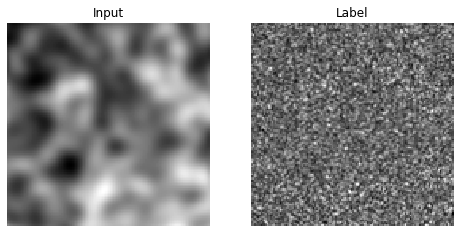

In [ ]:
x_tmp, y_tmp = next(iter(trainloader))
print(x_tmp.shape)
print(y_tmp.shape)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(x_tmp[0].squeeze(), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow(y_tmp[0].squeeze(), cmap='gray')
plt.axis('off')
plt.title('Label')

# Define Network Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.autograd import Variable
import torch.nn.functional as F

In [ ]:

def conv_stage(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, BN=False):
  if BN:
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )
  else:
    return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )


class CNN(nn.Module):
  def __init__(self, BN=False):
    super(CNN, self).__init__()

    self.conv1   = conv_stage(1, 32, BN=BN)
    self.conv2   = conv_stage(32, 64, BN=BN)
    self.conv3   = conv_stage(64, 64, BN=BN)
    self.conv4   = conv_stage(64, 64, BN=BN)
    self.conv5   = conv_stage(64, 64, BN=False)
    self.conv0  = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
          
    ## Xavier initialization
    for con in self.modules():
      if isinstance(con, nn.Conv2d):
        nn.init.xavier_uniform_(con.weight)
        if con.bias is not None:
          con.bias.data.fill_(0.01)

  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(conv1_out)
    conv3_out = self.conv3(conv2_out)
    conv4_out = self.conv4(conv3_out)
    conv5_out = self.conv5(conv4_out)
    conv0_out = self.conv0(conv5_out)

    return conv0_out

In [ ]:
net = CNN(BN=True).cuda()

# Training Process

In [ ]:
def show_output(model, _X,_Y, save_name):  # This shows output intermediate stage
    model.eval()

    sn, sx, sy, sch = _X.shape
    resY = model(_X)
    resY = resY.cpu().detach().numpy()
    _X = _X.detach().cpu().detach().numpy()    
    
    fig = plt.figure(figsize=(16,8))
    
    plt.subplot(1,3,1)
    plt.imshow(_X.squeeze(),cmap='gray',vmin=0,vmax=0.5)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(resY.squeeze(),cmap='gray',vmin=0,vmax=0.5)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(_Y.squeeze(),cmap='gray',vmin=0,vmax=0.5)
    plt.axis('off')
    
    plt.savefig(save_name, transparent=True, bbox_inches='tight')

In [ ]:
!pip install livelossplot # Beautiful liveloss plot for jupyter

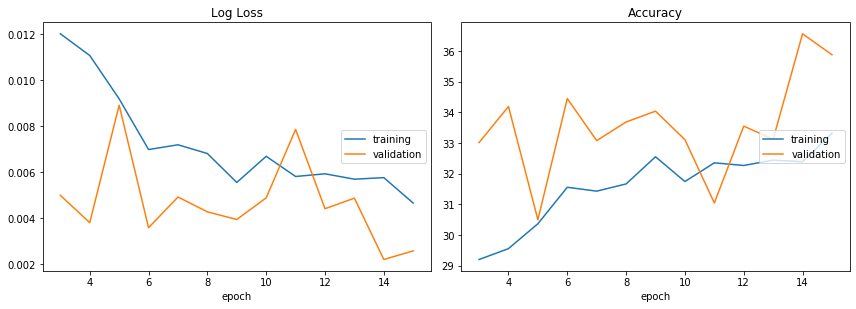

Log Loss:
training   (min:    0.005, max:    0.109, cur:    0.005)
validation (min:    0.002, max:    0.034, cur:    0.003)

Accuracy:
training   (min:   19.645, max:   33.319, cur:   33.319)
validation (min:   24.627, max:   36.563, cur:   35.879)


In [ ]:
%matplotlib inline

from livelossplot import PlotLosses 
from IPython.display import clear_output
import os
import time
if not os.path.exists('Result_images'):
    os.makedirs('Result_images')

val_X_test = Variable(torch.from_numpy(X_val[100:101]),requires_grad=False).cuda()
val_Y_test = Y_val[100:101]

optimizer = torch.optim.Adam(net.parameters(),lr=0.0002)

criterion = torch.nn.MSELoss()

liveloss = PlotLosses()

for epoch in range(15): 
    logs = {}
    for phase in ['train', 'validation']:
        if phase == 'train':
            net.train()
        else:
            net.eval()
        
        running_loss = 0.0
        running_mse = 0.0
        
        for inputs, labels in dataloaders[phase]: # get the inputs 

            inputs, labels = Variable(inputs).cuda(), Variable(labels, requires_grad=False).cuda() 
            # Forward pass: Compute predicted y by passing x to the model 
            if phase == 'train':
                y_pred = net(inputs) # Compute and print loss 
                mse_loss = criterion(y_pred, labels)
                loss = mse_loss
            else:
                with torch.no_grad():
                    y_pred = net(inputs) # Compute and print loss 
                    mse_loss = criterion(y_pred, labels)
                    loss = mse_loss
                    
            # Zero gradients, perform a backward pass, and update the weights.             
            if phase == 'train':
                optimizer.zero_grad() 
                loss.backward() 
                optimizer.step()
            running_mse += mse_loss.detach() * inputs.size(0)
            running_loss += loss.detach() * inputs.size(0)
            
        epoch_loss = running_loss.item() / len(dataloaders[phase].dataset)
        epoch_mse = running_mse.item() / len(dataloaders[phase].dataset)
        epoch_psnr = 10 * np.log10(1/epoch_mse) 
        prefix = ''
        if phase == 'validation':
            with torch.no_grad():
                prefix = 'val_'
                if epoch % 5 == 0:                  
                    clear_output()
                    print('Validation data Epoch:' + str(epoch))
                    save_name = 'Result_images/Val_Epoch_'+str(epoch)+'.jpg'
                    show_output(net, val_X_test, val_Y_test, save_name)
                    # Show outputs (and save it to result_images folder)
                    plt.show()
                    time.sleep(3)
                
        logs[prefix+'Log Loss'] = epoch_loss*10            
        logs[prefix+'Accuracy'] = epoch_psnr # For Accuracy I used PSNR metric

    liveloss.update(logs)
    liveloss.draw()
    

# Evaluate on Testing Data

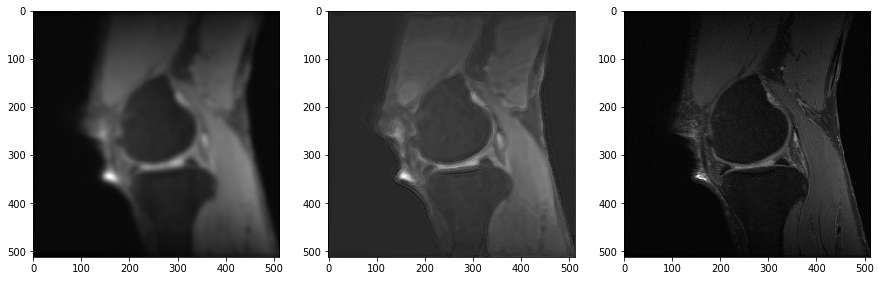

In [ ]:
X_testc = torch.from_numpy(X_test[100:101]).cuda()  #torch로 변환

with torch.no_grad():  #backpropagation을 계산하지 말라는것. (메모리때문에)
  out = net(X_testc)

out = out.detach().cpu().numpy()    #numpy로 변환

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(X_test[100].squeeze(), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(out.squeeze(), cmap='gray')
plt.subplot(1,3,3)
plt.imshow(Y_test[100].squeeze(), cmap='gray')

# PSNR, SSIM: Use skimage.measure import compare_psnr, compare_ssim




In [ ]:
from skimage.measure import compare_psnr, compare_ssim


In [ ]:
?compare_psnr


In [ ]:
from skimage.measure import compare_psnr, compare_ssim

X_slice = X_test[100].squeeze()
DL_slice = out.squeeze()
Y_slice = Y_test[100].squeeze()

print('SSIM of Gaussian Blurred: {:3.3f}'.format(compare_ssim(X_slice, Y_slice)))
print('SSIM of Gaussian Blurred: {:3.3f}'.format(compare_ssim(DL_slice, Y_slice)))

SSIM of Gaussian Blurred: 0.959
SSIM of Gaussian Blurred: 0.958


In [ ]:
print('PSNR of Gaussian Blurred: {:3.4f}dB'.format(compare_psnr(X_slice, Y_slice)))
print('PSNR of DL results: {:3.4f}dB'.format(compare_psnr(DL_slice, Y_slice)))

PSNR of Gaussian Blurred: 35.6728dB
PSNR of DL results: 41.1259dB
